### IMDB Movie Reviews Sentiment Classification

#### Solution workflow: -

* Extract train & test sentences containing 'max_features' most frequent tokens from Keras in-built IMDB dataset (tokens are Positional Index into its vocabulary)... all infrequent tokens are represented by some constant.

* Trim/pad sentences to 'sent_max_len' words (same as LSTM input's timesteps param and also the LSTM 'units') https://stackoverflow.com/questions/44273249/in-keras-what-exactly-am-i-configuring-when-i-create-a-stateful-lstm-layer-wi

* Define Supervised ML network
    * Embedding represents each token as 'word_vec_len' x 1 Word Vector... Not sure what pre-trained embedding does Keras+IMDB deriving??
    * LSTM many-to-one takes in batch of sentence, i.e., batch_size x sent_max_len x word_vec_len
    * Binary Sigmoid layer for binary classification

* Fit model with train & validate (same as test) labeled sentences

* Evaluate accuracy with test sentences


#### Extending this base solution further: - 

* Multi label classification

* Use either of the RNN, LSTM or GRU

* Use explicit Embeddings matrix - either existing pre-trained embeddings (Word2Vec, GloVe, etc) or train your own Embeddings with given text corpus using Gensim

* Use forward directional LSTM or bi-directional LSTM. Bi-directional is better, e.g., meaning of Teddy in “He said, Teddy bears are on sale” -vs- “He said, Teddy Roosevelt was a great President”

* Use STATEFUL LSTM for seq-2-seq use cases (speech synthesis, machine translation, Q&A) - http://philipperemy.github.io/keras-stateful-lstm/ 


#### Reference: -
This solution is adapted from reference example https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py 


In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, Bidirectional

from sklearn.model_selection import train_test_split

from keras.datasets import imdb

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Most frequent tokens, i.e., vocab size
max_features = 5000

# Words / tokens count in Sentence which is also the LSTM input's timesteps param
sent_max_len = 100

# Batches of setences to feed into neural net
batch_size = 32

# Word vector length, i.e., dimension of the dense embedding
word_vec_len = 64

# LSTM output size assuming we are using many as output which will be ultimately connected to dense layer to match up the label classes
lstm_out_size = 64

# NN training epochs
n_epochs = 10

In [3]:
print('Loading data...')

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [4]:
mylen = np.vectorize(len)
print(mylen(x_train).min(), mylen(x_train).max())

11 2494


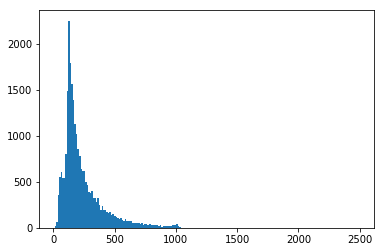

In [5]:
plt.hist(mylen(x_train), 200)
plt.show()

In [6]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2)
print(len(x_train), 'train sequences after train-validate split')
print(len(x_validate), 'validate sequences after train-validate split')

20000 train sequences after train-validate split
5000 validate sequences after train-validate split


In [7]:
# Trim long sentences or pad short ones
# What is the implication of trimming lonnng setences to max_len

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=sent_max_len)
x_validate = sequence.pad_sequences(x_validate, maxlen=sent_max_len)
x_test = sequence.pad_sequences(x_test, maxlen=sent_max_len)

print('x_train shape:', x_train.shape)
print('x_validate shape:', x_validate.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (20000, 100)
x_validate shape: (5000, 100)
x_test shape: (25000, 100)


In [8]:
x_train[0]

array([  10,    4,  489,    7,  458,    9,   55,  338,    5,   49, 1317,
          5,    2,  139,   28,   77,  862, 2400,    6,  128,  167,  100,
         28,   93,    6,  976,  921,  453,   46,    7,    4,  875,   10,
         10,    4,  116,  421, 1639,  261,    2,    2,  839,   49,  113,
         83,    4,  217,    4,  409,   71, 1053,   13,  210,  197,   15,
          2,    2,   16,    6,   52,  524,   21,   41,  676,    9,   24,
       3523,   11,   14,   22,    4,  915,  832,   71,    2, 1916,   10,
         10,   11,  420,   25,   26,    6,  337,    7,  703,    5,  657,
          8,   67,   53,    7,    4,  167,  789,  245,   39,   14,   31,
        591])

In [9]:
#'''
print('Build LSTM based network...')

model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=word_vec_len))
model.add(LSTM(units=lstm_out_size, input_shape=(sent_max_len, word_vec_len), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())
#'''

Build LSTM based network...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 353,089
Trainable params: 353,089
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
'''
# Observe that Bi-di LSTM output size is 2*units, i.e., units output for usual left-2-right & another set of units for right-2-left
# NOTE that both l2r & r2l are forward passes (don't confuse with backprop)

print('Build bi-directional LSTM based network model...')

model = Sequential()

# input_length=sent_max_len
model.add(Embedding(input_dim=max_features, output_dim=word_vec_len))
model.add(Bidirectional(LSTM(units=lstm_out_size)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())
'''

"\nprint('Build bi-directional LSTM based network model...')\n\nmodel = Sequential()\n\n# input_length=sent_max_len\nmodel.add(Embedding(input_dim=max_features, output_dim=word_vec_len))\nmodel.add(Bidirectional(LSTM(units=lstm_out_size)))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1, activation='sigmoid'))\n\nprint(model.summary())\n"

In [11]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model_fitting_history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          validation_data=(x_validate, y_validate))

Train...
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.4927 - acc: 0.7536 - val_loss: 0.4151 - val_acc: 0.8148
Epoch 2/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.3561 - acc: 0.8492 - val_loss: 0.4623 - val_acc: 0.7794
Epoch 3/10
20000/20000 [==============================] - 74s 4ms/step - loss: 0.3219 - acc: 0.8654 - val_loss: 0.4236 - val_acc: 0.8204
Epoch 4/10
20000/20000 [==============================] - 76s 4ms/step - loss: 0.2814 - acc: 0.8864 - val_loss: 0.3911 - val_acc: 0.8264
Epoch 5/10
20000/20000 [==============================] - 76s 4ms/step - loss: 0.2476 - acc: 0.9012 - val_loss: 0.4176 - val_acc: 0.8358
Epoch 6/10
20000/20000 [==============================] - 74s 4ms/step - loss: 0.2186 - acc: 0.9127 - val_loss: 0.4058 - val_acc: 0.8394
Epoch 7/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.1944 - acc: 0.9244 - val_loss: 0.4595 -

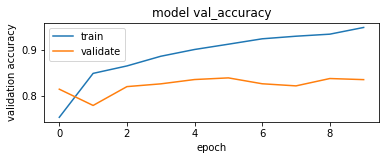

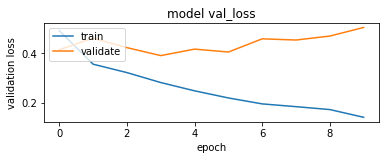

In [12]:
plt.figure(1)
plt.subplot(211)
plt.plot(model_fitting_history.history['acc'])
plt.plot(model_fitting_history.history['val_acc'])
plt.title('model val_accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

plt.figure(2)
plt.subplot(212)
plt.plot(model_fitting_history.history['loss'])
plt.plot(model_fitting_history.history['val_loss'])
plt.title('model val_loss')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

plt.show()

In [13]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 12s 500us/step
Test score: 0.5135944603633881
Test accuracy: 0.83104
